# Extended Kalman filter example (PVTOL)

This notebook illustrates the implementation of an extended Kalman filter and the use of the estimated state for LQR feedback.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import control as ct

## System definition
The dynamics of the system
with disturbances on the $x$ and $y$ variables is given by
$$
  \begin{aligned}
    m \ddot x &= F_1 \cos\theta - F_2 \sin\theta - c \dot x + d_x, \\
    m \ddot y &= F_1 \sin\theta + F_2 \cos\theta - c \dot y - m g + d_y, \\
    J \ddot \theta &= r F_1.
  \end{aligned}
$$
The measured values of the system are the position and orientation,
with added noise $n_x$, $n_y$, and $n_\theta$:
$$
  \vec y = \begin{bmatrix} x \\ y \\ \theta \end{bmatrix} + 
  \begin{bmatrix} n_x \\ n_y \\ n_z \end{bmatrix}.
$$


In [2]:
# pvtol = nominal system (no disturbances or noise)
# noisy_pvtol = pvtol w/ process disturbances and sensor noise
from pvtol import pvtol, pvtol_noisy, plot_results

# Find the equilibrium point corresponding to the origin
xe, ue = ct.find_eqpt(
    pvtol, np.zeros(pvtol.nstates),
    np.zeros(pvtol.ninputs), [0, 0, 0, 0, 0, 0],
    iu=range(2, pvtol.ninputs), iy=[0, 1])

x0, u0 = ct.find_eqpt(
    pvtol, np.zeros(pvtol.nstates),
    np.zeros(pvtol.ninputs), np.array([2, 1, 0, 0, 0, 0]),
    iu=range(2, pvtol.ninputs), iy=[0, 1])

# Extract the linearization for use in LQR design
pvtol_lin = pvtol.linearize(xe, ue)
A, B = pvtol_lin.A, pvtol_lin.B

print(pvtol, "\n")
print(pvtol_noisy)

<FlatSystem>: pvtol
Inputs (2): ['F1', 'F2']
Outputs (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']
States (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']
Parameters: ['m', 'J', 'r', 'g', 'c']

Update: <function _pvtol_update at 0x1139909a0>
Output: <function _pvtol_output at 0x14449c860>

Forward: <function _pvtol_flat_forward at 0x14449c900>
Reverse: <function _pvtol_flat_reverse at 0x14449e700> 

<NonlinearIOSystem>: pvtol_noisy
Inputs (7): ['F1', 'F2', 'Dx', 'Dy', 'Nx', 'Ny', 'Nth']
Outputs (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']
States (6): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']

Update: <function _noisy_update at 0x14449eac0>
Output: <function _noisy_output at 0x14449eb60>


We now define the properties of the noise and disturbances.  To make things (a bit more) interesting, we include some cross terms between the noise in $\theta$ and the noise in $x$ and $y$:

In [3]:
# Disturbance and noise intensities
Qv = np.diag([1e-2, 1e-2])
Qw = np.array([[2e-4, 0, 1e-5], [0, 2e-4, 1e-5], [1e-5, 1e-5, 1e-4]])
Qwinv = np.linalg.inv(Qw)

# Initial state covariance
P0 = np.eye(pvtol.nstates)

## Control system design

To design the control system, we first construct an estimator for the state (given the commanded inputs and measured outputs.  Since this is a nonlinear system, we use the update law for the nominal system to compute the state update.  We also make use of the linearization around the current state for the covariance update (using the function `pvtol.A(x, u)`, which is defined in `pvtol.py`, making this an extended Kalman filter).

In [4]:
# Define the disturbance input and measured output matrices
F = np.array([[0, 0], [0, 0], [0, 0], [1/pvtol.params['m'], 0], [0, 1/pvtol.params['m']], [0, 0]])
C = np.eye(3, 6)

# Estimator update law
def estimator_update(t, x, u, params):
    # Extract the states of the estimator
    xhat = x[0:pvtol.nstates]
    P = x[pvtol.nstates:].reshape(pvtol.nstates, pvtol.nstates)

    # Extract the inputs to the estimator
    y = u[0:3]                  # just grab the first three outputs
    u = u[6:8]                  # get the inputs that were applied as well

    # Compute the linearization at the current state
    A = pvtol.A(xhat, u)        # A matrix depends on current state
    # A = pvtol.A(xe, ue)       # Fixed A matrix (for testing/comparison)
    
    # Compute the optimal again
    L = P @ C.T @ Qwinv

    # Update the state estimate
    xhatdot = pvtol.updfcn(t, xhat, u, params) - L @ (C @ xhat - y)

    # Update the covariance
    Pdot = A @ P + P @ A.T - P @ C.T @ Qwinv @ C @ P + F @ Qv @ F.T

    # Return the derivative
    return np.hstack([xhatdot, Pdot.reshape(-1)])

def estimator_output(t, x, u, params):
    # Return the estimator states
    return x[0:pvtol.nstates]

estimator = ct.NonlinearIOSystem(
    estimator_update, estimator_output,
    states=pvtol.nstates + pvtol.nstates**2,
    inputs= pvtol_noisy.output_labels \
        + pvtol_noisy.input_labels[0:pvtol.ninputs],
    outputs=[f'xh{i}' for i in range(pvtol.nstates)],
)
print(estimator)

<NonlinearIOSystem>: sys[1]
Inputs (8): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'F1', 'F2']
Outputs (6): ['xh0', 'xh1', 'xh2', 'xh3', 'xh4', 'xh5']
States (42): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]', 'x[9]', 'x[10]', 'x[11]', 'x[12]', 'x[13]', 'x[14]', 'x[15]', 'x[16]', 'x[17]', 'x[18]', 'x[19]', 'x[20]', 'x[21]', 'x[22]', 'x[23]', 'x[24]', 'x[25]', 'x[26]', 'x[27]', 'x[28]', 'x[29]', 'x[30]', 'x[31]', 'x[32]', 'x[33]', 'x[34]', 'x[35]', 'x[36]', 'x[37]', 'x[38]', 'x[39]', 'x[40]', 'x[41]']

Update: <function estimator_update at 0x14449f6a0>
Output: <function estimator_output at 0x14449f7e0>


For the controller, we will use an LQR feedback with physically motivated weights (see OBC, Example 3.5):

In [5]:
#
# LQR design w/ physically motivated weighting
#
# Shoot for 1 cm error in x, 10 cm error in y.  Try to keep the angle
# less than 5 degrees in making the adjustments.  Penalize side forces
# due to loss in efficiency.
#

Qx = np.diag([100, 10, (180/np.pi) / 5, 0, 0, 0])
Qu = np.diag([10, 1])
K, _, _ = ct.lqr(A, B, Qx, Qu)

#
# Control system construction: combine LQR w/ EKF
#
# Use the linearization around the origin to design the optimal gains
# to see how they compare to the final value of P for the EKF
#

# Construct the state feedback controller with estimated state as input
statefbk, _ = ct.create_statefbk_iosystem(pvtol, K, estimator=estimator)
print(statefbk, "\n")

# Reconstruct the control system with the noisy version of the process
# Create a closed loop system around the controller
clsys = ct.interconnect(
    [pvtol_noisy, statefbk, estimator],
    inplist = statefbk.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        pvtol_noisy.input_labels[pvtol.ninputs:],
    inputs = statefbk.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        pvtol_noisy.input_labels[pvtol.ninputs:],
    outlist = pvtol.output_labels + statefbk.output_labels + estimator.output_labels,
    outputs = pvtol.output_labels + statefbk.output_labels + estimator.output_labels
)
print(clsys)

<StateSpace>: sys[2]
Inputs (14): ['xd[0]', 'xd[1]', 'xd[2]', 'xd[3]', 'xd[4]', 'xd[5]', 'ud[0]', 'ud[1]', 'xh0', 'xh1', 'xh2', 'xh3', 'xh4', 'xh5']
Outputs (2): ['F1', 'F2']
States (0): []

A = []

B = []

C = []

D = [[-3.16227766e+00 -1.31948922e-07  8.67680175e+00 -2.35855555e+00
      -6.98881821e-08  1.91220852e+00  1.00000000e+00  0.00000000e+00
       3.16227766e+00  1.31948922e-07 -8.67680175e+00  2.35855555e+00
       6.98881821e-08 -1.91220852e+00]
     [-1.31948921e-06  3.16227766e+00 -2.32324826e-07 -2.36396240e-06
       4.97998224e+00  7.90913276e-08  0.00000000e+00  1.00000000e+00
       1.31948921e-06 -3.16227766e+00  2.32324826e-07  2.36396240e-06
      -4.97998224e+00 -7.90913276e-08]] 

<InterconnectedSystem>: sys[3]
Inputs (13): ['xd[0]', 'xd[1]', 'xd[2]', 'xd[3]', 'xd[4]', 'xd[5]', 'ud[0]', 'ud[1]', 'Dx', 'Dy', 'Nx', 'Ny', 'Nth']
Outputs (14): ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'F1', 'F2', 'xh0', 'xh1', 'xh2', 'xh3', 'xh4', 'xh5']
States (48): ['pvtol_noisy_x0',

Note that we have to construct the closed loop system manually since we need to allow the disturbance and noise inputs to be sent to the closed loop system and `create_statefbk_iosystem` does not support this (to be fixed in an upcoming release).

## Simulations

Finally, we can simulate the system to see how it all works.  We start by creating the noise for the system:

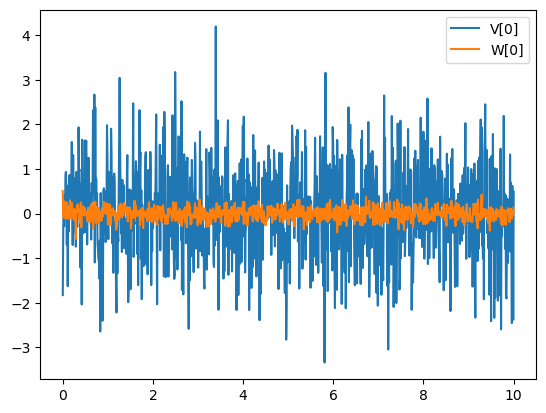

In [6]:
# Create the time vector for the simulation
Tf = 10
timepts = np.linspace(0, Tf, 1000)

# Create representative process disturbance and sensor noise vectors
np.random.seed(117)           # avoid figures changing from run to run
V = ct.white_noise(timepts, Qv) # smaller disturbances and noise then design
W = ct.white_noise(timepts, Qw)
plt.plot(timepts, V[0], label="V[0]")
plt.plot(timepts, W[0], label="W[0]")
plt.legend();

### LQR with EKF

We can now feed the desired trajectory plus the noise and disturbances into the system and see how well the controller with a state estimator does in holding the system at an equilibrium point:

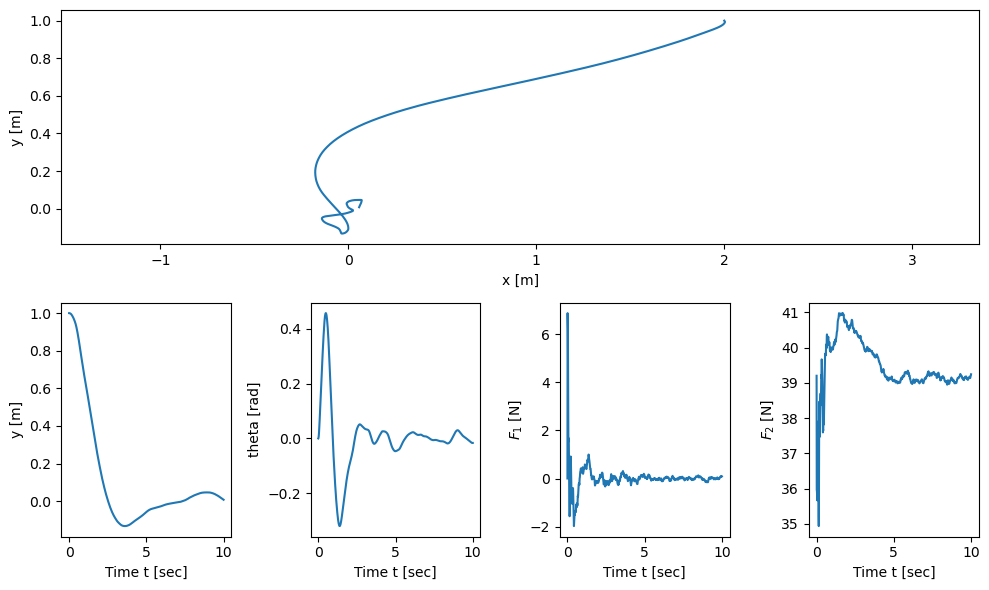

In [7]:
# Put together the input for the system
U = [xe, ue, V, W]
X0 = [x0, xe, P0.reshape(-1)]

# Initial condition response
resp = ct.input_output_response(clsys, timepts, U, X0)

# Plot the response
plot_results(timepts, resp.states, resp.outputs[pvtol.nstates:])

To see how well the estimtator did, we can compare the estimated position with the actual position:

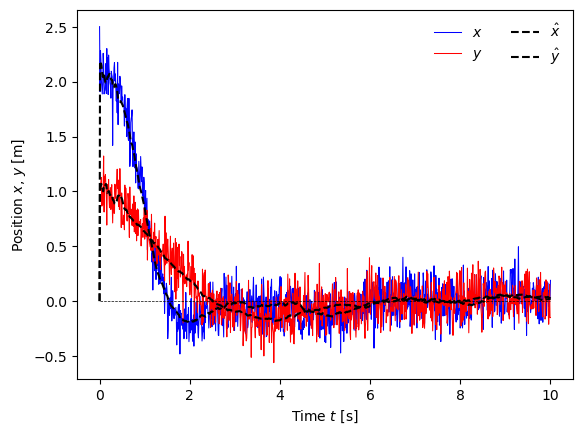

In [8]:
# Response of the first two states, including internal estimates
h1, = plt.plot(resp.time, resp.outputs[0], 'b-', linewidth=0.75)
h2, = plt.plot(resp.time, resp.outputs[1], 'r-', linewidth=0.75)

# Add on the internal estimator states
xh0 = clsys.find_output('xh0')
xh1 = clsys.find_output('xh1')
h3, = plt.plot(resp.time, resp.outputs[xh0], 'k--')
h4, = plt.plot(resp.time, resp.outputs[xh1], 'k--')

plt.plot([0, 10], [0, 0], 'k--', linewidth=0.5)
plt.ylabel(r"Position $x$, $y$ [m]")
plt.xlabel(r"Time $t$ [s]")
plt.legend(
    [h1, h2, h3, h4], ['$x$', '$y$', r'$\hat{x}$', r'$\hat{y}$'], 
    loc='upper right', frameon=False, ncol=2);

Note the rapid convergence of the estimate to the proper value, since we are directly measuring the position variables.  If we look at the full set of states, we see that other variables have different convergence properties:

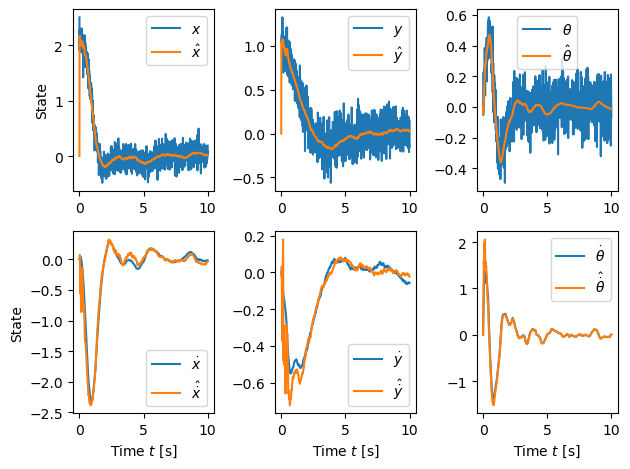

In [9]:
fig, axs = plt.subplots(2, 3)
var = ['x', 'y', r'\theta', r'\dot x', r'\dot y', r'\dot \theta']
for i in [0, 1]:
    for j in [0, 1, 2]:
        k = i * 3 + j
        axs[i, j].plot(resp.time, resp.outputs[k], label=f'${var[k]}$')
        axs[i, j].plot(resp.time, resp.outputs[xh0+k], label=f'$\\hat {var[k]}$')
        axs[i, j].legend()
        if i == 1:
            axs[i, j].set_xlabel("Time $t$ [s]")
        if j == 0:
            axs[i, j].set_ylabel("State")
plt.tight_layout()

Note the lag in tracking changes in the $\dot x$ and $\dot y$ states (varies from simulation to simulation, depending on the specific noise signal).

### Full state feedback

To see how the inclusion of the estimator affects the system performance, we compare it with the case where we are able to directly measure the state of the system.

/Users/murray/Library/CloudStorage/Dropbox/macosx/src/python-control/murrayrm/control/statefbk.py:788: UserWarning: cannot verify system output is system state
  warnings.warn("cannot verify system output is system state")


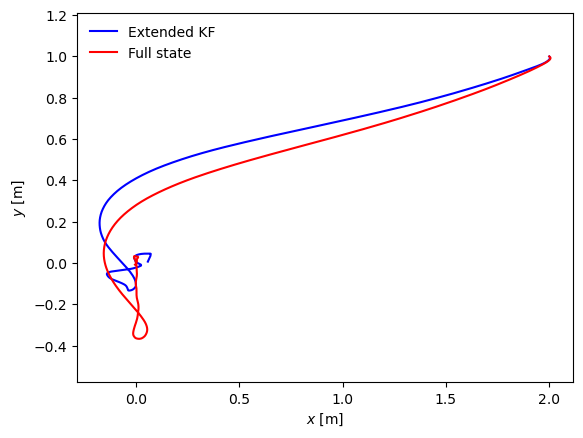

In [10]:
# Compute the full state feedback solution
lqr_ctrl, _ = ct.create_statefbk_iosystem(pvtol, K)

lqr_clsys = ct.interconnect(
    [pvtol_noisy, lqr_ctrl],
    inplist = lqr_ctrl.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        pvtol_noisy.input_labels[pvtol.ninputs:],
    inputs = lqr_ctrl.input_labels[0:pvtol.ninputs + pvtol.nstates] + \
        pvtol_noisy.input_labels[pvtol.ninputs:],
    outlist = pvtol.output_labels + lqr_ctrl.output_labels,
    outputs = pvtol.output_labels + lqr_ctrl.output_labels
)

# Put together the input for the system (turn off sensor noise)
U = [xe, ue, V, W*0]

# Run a simulation with full state feedback
lqr_resp = ct.input_output_response(lqr_clsys, timepts, U, x0)

# Compare the results
plt.plot(resp.states[0], resp.states[1], 'b-', label="Extended KF")
plt.plot(lqr_resp.states[0], lqr_resp.states[1], 'r-', label="Full state")

plt.xlabel('$x$ [m]')
plt.ylabel('$y$ [m]')
plt.axis('equal')
plt.legend(frameon=False);